# Introduction to `keras` and `tensorflow`

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import load_digits, load_sample_images

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
    
%load_ext autoreload
%autoreload 2

## Learning Goals

- Describe the concept of backpropagation
- Explain the use of gradient descent in neural networks
- Use `keras` to code up a neural network model

In [2]:
digits = load_digits()
flat_image = np.array(digits.data[0]).reshape(digits.data[0].shape[0], -1)
eight_by_eight_image = digits.images[0]

In [3]:
eight_by_eight_image

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

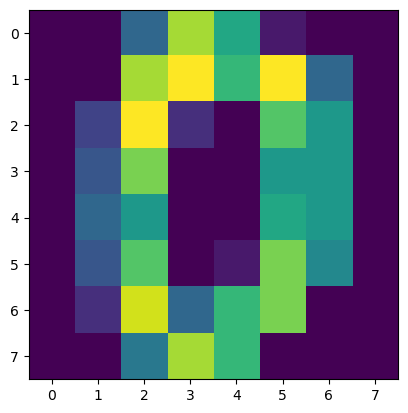

In [4]:
plt.imshow(eight_by_eight_image);

In [5]:
digits.target

array([0, 1, 2, ..., 8, 9, 8])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(digits.data,
                                                    digits.target,
                                                    random_state=42,
                                                    test_size=0.2)
X_train.shape

(1437, 64)

In [7]:
# Z is the input from our collector, the sum of the weights
# multiplied by the features and the bias

def sigmoid(z):
    '''
    Input the sum of our weights times the pixel intensities, plus the bias
    Output a number between 0 and 1.
    
    '''
    return 1/(1+np.e**(-z))

In [8]:
# Simulation from last time

w_1 = np.random.normal(0, 0.1, (X_train.shape[1], 1))
w_1.shape

(64, 1)

In [9]:
b_1 = 0

z_1 = X_train.dot(w_1) + b_1
z_1

output = sigmoid(z_1)
y_pred = output > 0.5
y_hat = y_pred.astype(int)
y_hat[:5]

array([[0],
       [1],
       [1],
       [1],
       [0]])

## Back propagation

After a certain number of data points have been passed through the model, the weights will be *updated* with an eye toward optimizing our loss function. (Thinking back to biological neurons, this is like revising their activation potentials.) Typically, this is  done  by using some version of gradient descent.

![bprop](images/BackProp_web.png)

### Function Approximation

[Neural networks are much like computational graphs](https://medium.com/tebs-lab/deep-neural-networks-as-computational-graphs-867fcaa56c9).

And computational graphs can be used [to approximate *any* function](http://neuralnetworksanddeeplearning.com/chap4.html).

### Loss Function

If we're thinking of networks, then, as function approximators, of course we'll want to know how good the approximation is. And so once again we have the idea of a [loss function](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html), which is of course what licenses our thinking of networks as models in the first place.

Many loss functions are available. Your choice will depend in part on whether you're doing a regression or classification problem.

Regression:

- mean / median absolute error
- mean / median squared error
- [Huber loss](https://en.wikipedia.org/wiki/Huber_loss)

Classification:

- Crossentropy
- [Hinge loss](https://en.wikipedia.org/wiki/Hinge_loss)
- [Kullback-Leibler divergence](https://www.countbayesie.com/blog/2017/5/9/kullback-leibler-divergence-explained)

The loss function tells us how well our model performed by comparing the predictions to the actual values.

When we train our models with `keras`, we will watch the loss function's progress across epochs.  A decreasing loss function will show us that our model is **improving**.

The loss function is associated with the nature of our output. In logistic regression, our output was binary, so our loss function was the negative loglikelihood, aka **cross-entropy**.

$$ \Large -\ loglikelihood = -\frac{1}{m} * \sum\limits_{i=1}^m y_i\log{p_i} + (1-y_i)\log(1-p_i) $$
    

In [10]:
y_train

array([6, 0, 0, ..., 2, 7, 1])

In [11]:
y_train = y_train % 2

In [12]:
y_train

array([0, 0, 0, ..., 0, 1, 1])

In [14]:
y_train*np.log(output) + (1-y_train) * np.log(1-output)

array([[-2.78027244e-03, -2.78027244e-03, -2.78027244e-03, ...,
        -2.78027244e-03, -5.88659617e+00, -5.88659617e+00],
       [-2.51965905e+00, -2.51965905e+00, -2.51965905e+00, ...,
        -2.51965905e+00, -8.39111451e-02, -8.39111451e-02],
       [-3.84340287e+00, -3.84340287e+00, -3.84340287e+00, ...,
        -3.84340287e+00, -2.16533362e-02, -2.16533362e-02],
       ...,
       [-2.23406341e+00, -2.23406341e+00, -2.23406341e+00, ...,
        -2.23406341e+00, -1.13272158e-01, -1.13272158e-01],
       [-6.06754472e+00, -6.06754472e+00, -6.06754472e+00, ...,
        -6.06754472e+00, -2.31954281e-03, -2.31954281e-03],
       [-3.24849606e-01, -3.24849606e-01, -3.24849606e-01, ...,
        -3.24849606e-01, -1.28242465e+00, -1.28242465e+00]])

In [15]:
neg_ll = -1/len(y_train)*np.sum(y_train*np.log(output) + (1-y_train) * np.log(1-output))
neg_ll

2549.3021581624403

For continuous variables, the loss function we have relied on is [MSE or MAE](http://rishy.github.io/ml/2015/07/28/l1-vs-l2-loss/).

Good [resource](https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/) on backpropogation with RMSE loss function.

Here is a good summary of different [loss functions](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html)

## Gradient Descent, Epochs, and Batches

We not only use the the loss function to see how our model is improving; we also use it to update our parameters. The gradient of the loss function is calculated in relation to each parameter of our neural net.

For a deep dive into the fitting process, reference Chapter 11 in [Elements of Statistical Learning](https://web.stanford.edu/~hastie/ElemStatLearn/printings/ESLII_print12.pdf)

Gradient descent can be performed in several different ways.  Unlike the `sklearn` implementation of linear regression, which finds the minimum of the loss with a closed form solution, neural networks move down the gradient **incrementally**.

When we fit our neural nets in Keras, we can set the hyperparameter `verbose` equal to 1, and we will see progress through **epochs**. Setting `verbose` to 2 will show just the epoch numbers as they progress.

At the end of each epoch, **all examples** from our training set have passed through the network.

Different types of gradient descent update the parameters at different times.

### Batch Gradient Descent

The gradient is calculated across all values.  We can find the direction of the gradient, and proceed directly towards the minimum.

The weights are updated with regard to the cost at the **end of an epoch** after all training elements have passed through.

### Stochastic Gradient Descent

Updating the weights after all training examples have passed through can be detrimentally slow.  

SGD updates the weights after each training **example**. SGD requires fewer epochs to achieve quality coefficients. This speeds up gradient descent [significantly](https://machinelearningmastery.com/gradient-descent-for-machine-learning/).

### Mini-Batch Gradient Descent

In mini-batch, we pass a batch, calculate the gradient, update the params, then proceed to the next batch. It combines the advantages of batch and stochastic gradient descent: it is faster than SGD since the updates are not made with each point, and more computationally efficient than batch, since we don't have to hold all training examples in memory.

[Good comparison of types of Gradient Descent and batch size](https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/)

In [16]:
1000 / 32

31.25

In [ ]:
1000

## Optimizers

One of the levers we can tweak are the optimizers which control how the weights and biases are updated.

For stochastic gradient descent, the weights are updated with a **constant** learning rate (alpha) after every record.  If we specify a batch size, the constant learning rate is multiplied by the gradient across the batch. 

Other optimizers, such as **Adam** ("Adaptive Moment Estimation"), update the weights in different ways. For Adam,
> A learning rate is maintained for each network weight (parameter) and separately adapted as learning unfolds. See [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/).

![backprop](images/ff-bb.gif)

The graphic above can be a bit frustrating since it moves fast, but follow the progress as so:

Forward propagation with the **blue** tinted arrows computes the output of each layer: i.e. a summation and activation.

Backprop calculates the partial derivative (**green** circles) for each weight (**brown** line) and bias.

Then the optimizer multiplies a **learning rate** ($\eta$) to each partial derivative to calculate a new weight which will be applied to the next batch that passes through.

## Tensorflow and Keras

In [17]:
import keras

Wait a second, what is that warning? 
`Using TensorFlow backend.`

<img align =left src="images/keras.png"><br>

### Keras is an API

It can be layered on top of many different back-end processing systems.

![kerasback](images/keras_tf_theano.png)

While each of these systems has its own coding methods, `keras` abstracts from that in the streamlined Pythonic manner we are used to seeing in other Python modeling libraries.

Keras development is backed primarily by Google, and the Keras API comes packaged in TensorFlow as tf.keras. Additionally, Microsoft maintains the CNTK Keras backend. Amazon AWS is maintaining the Keras fork with MXNet support. Other contributing companies include NVIDIA, Uber, and Apple (with CoreML).

Theano has been discontinued.  The last release was 2017, but can still be used.

We will use TensorFlow, as it is the most popular. TensorFlow became the most used Keras backend, and  eventually integrated Keras in via its `tf.keras` submodule.

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [20]:
import tensorflow as tf

## Building a Binary Classifier NN

In [21]:
digits = load_digits()
X = digits.data.astype('float32')
y = digits.target.astype('float32')

In [22]:
X

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]], dtype=float32)

In [23]:
y

array([0., 1., 2., ..., 8., 9., 8.], dtype=float32)

We will start with a binary classification, and predict whether the number will be even or odd.

In [24]:
y_binary = y % 2
y_binary

array([0., 1., 0., ..., 0., 1., 0.], dtype=float32)

### Initialize a Linear Stack of Layers

In [88]:
model = Sequential()

In [89]:
model

### Add Densely Connected Layers

In [90]:
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [91]:
model

In [92]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 12)                780       
                                                                 
 dense_18 (Dense)            (None, 8)                 104       
                                                                 
 dense_19 (Dense)            (None, 1)                 9         
                                                                 
Total params: 893
Trainable params: 893
Non-trainable params: 0
_________________________________________________________________


In [93]:
# Weights plus bias
(64 * 12) + 12

780

In [94]:
(12 * 8) + 8

104

In [95]:
(8 * 1) + 1

9

### Compile the Model

The next step is new: After building the model we'll now **compile** it, which is a matter of yoking together the architecture with:
- the optimizer we want to use,
- the loss function we want to use, and
- the metrics we want to use.

In [96]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'])

In [97]:
model

In [98]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 12)                780       
                                                                 
 dense_18 (Dense)            (None, 8)                 104       
                                                                 
 dense_19 (Dense)            (None, 1)                 9         
                                                                 
Total params: 893
Trainable params: 893
Non-trainable params: 0
_________________________________________________________________


### Fit the Model

Now we're ready to **fit** it!

In [99]:
X.shape

(1797, 64)

In [100]:
X

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]], dtype=float32)

In [101]:
model.fit(X, y_binary, epochs=50, batch_size=1797, verbose=1)

Epoch 1/50
1/1 [==============================] - 0s 279ms/step - loss: 2.3565 - accuracy: 0.3968
Epoch 2/50
1/1 [==============================] - 0s 12ms/step - loss: 1.8645 - accuracy: 0.3500
Epoch 3/50
1/1 [==============================] - 0s 19ms/step - loss: 1.6687 - accuracy: 0.3634
Epoch 4/50
1/1 [==============================] - 0s 25ms/step - loss: 1.5317 - accuracy: 0.3701
Epoch 5/50
1/1 [==============================] - 0s 29ms/step - loss: 1.4248 - accuracy: 0.3817
Epoch 6/50
1/1 [==============================] - 0s 16ms/step - loss: 1.3370 - accuracy: 0.3968
Epoch 7/50
1/1 [==============================] - 0s 26ms/step - loss: 1.2598 - accuracy: 0.4079
Epoch 8/50
1/1 [==============================] - 0s 14ms/step - loss: 1.1924 - accuracy: 0.4257
Epoch 9/50
1/1 [==============================] - 0s 15ms/step - loss: 1.1318 - accuracy: 0.4480
Epoch 10/50
1/1 [==============================] - 0s 13ms/step - loss: 1.0764 - accuracy: 0.4613
Epoch 11/50
1/1 [===========

In [80]:
model.fit(X, y_binary, epochs=50, batch_size=1797, verbose=2)

Epoch 1/50
1/1 - 0s - loss: 0.2847 - accuracy: 0.8703 - 17ms/epoch - 17ms/step
Epoch 2/50
1/1 - 0s - loss: 0.2808 - accuracy: 0.8765 - 16ms/epoch - 16ms/step
Epoch 3/50
1/1 - 0s - loss: 0.2770 - accuracy: 0.8776 - 16ms/epoch - 16ms/step
Epoch 4/50
1/1 - 0s - loss: 0.2732 - accuracy: 0.8820 - 15ms/epoch - 15ms/step
Epoch 5/50
1/1 - 0s - loss: 0.2695 - accuracy: 0.8820 - 15ms/epoch - 15ms/step
Epoch 6/50
1/1 - 0s - loss: 0.2658 - accuracy: 0.8887 - 15ms/epoch - 15ms/step
Epoch 7/50
1/1 - 0s - loss: 0.2621 - accuracy: 0.8887 - 14ms/epoch - 14ms/step
Epoch 8/50
1/1 - 0s - loss: 0.2586 - accuracy: 0.8909 - 11ms/epoch - 11ms/step
Epoch 9/50
1/1 - 0s - loss: 0.2555 - accuracy: 0.8943 - 17ms/epoch - 17ms/step
Epoch 10/50
1/1 - 0s - loss: 0.2532 - accuracy: 0.8959 - 12ms/epoch - 12ms/step
Epoch 11/50
1/1 - 0s - loss: 0.2520 - accuracy: 0.8926 - 19ms/epoch - 19ms/step
Epoch 12/50
1/1 - 0s - loss: 0.2511 - accuracy: 0.8965 - 13ms/epoch - 13ms/step
Epoch 13/50
1/1 - 0s - loss: 0.2485 - accuracy: 0

In [63]:
model.fit(X, y_binary, epochs=50, batch_size=10, verbose=1)

Epoch 1/50
180/180 [==============================] - 2s 8ms/step - loss: 0.0558 - accuracy: 0.9827
Epoch 2/50
180/180 [==============================] - 1s 8ms/step - loss: 0.0503 - accuracy: 0.9833
Epoch 3/50
180/180 [==============================] - 1s 8ms/step - loss: 0.0460 - accuracy: 0.9866
Epoch 4/50
180/180 [==============================] - 1s 7ms/step - loss: 0.0415 - accuracy: 0.9839
Epoch 5/50
180/180 [==============================] - 1s 7ms/step - loss: 0.0377 - accuracy: 0.9894
Epoch 6/50
180/180 [==============================] - 1s 7ms/step - loss: 0.0344 - accuracy: 0.9889
Epoch 7/50
180/180 [==============================] - 1s 7ms/step - loss: 0.0304 - accuracy: 0.9894
Epoch 8/50
180/180 [==============================] - 1s 7ms/step - loss: 0.0264 - accuracy: 0.9911
Epoch 9/50
180/180 [==============================] - 1s 7ms/step - loss: 0.0252 - accuracy: 0.9905
Epoch 10/50
180/180 [==============================] - 1s 7ms/step - loss: 0.0217 - accuracy: 0.9928

In [62]:
1797 / 10 

179.7

In [102]:
model.get_weights()

[array([[-5.17072380e-02, -4.22232896e-02, -2.80859917e-01,
          2.71128744e-01,  1.60091966e-01,  1.73060387e-01,
         -1.57614946e-01, -1.45586789e-01, -1.17170244e-01,
         -2.51021683e-01, -1.93359658e-01, -1.63324893e-01],
        [-1.96191728e-01,  1.67657495e-01, -6.14784509e-02,
         -1.91949517e-01, -2.05349289e-02, -6.12837896e-02,
          2.06387684e-01, -1.75244994e-02,  2.47064278e-01,
          1.65570930e-01,  1.02976337e-02, -1.69457659e-01],
        [ 2.98304856e-01, -2.50293583e-01, -1.09529391e-01,
          2.64789283e-01,  1.12425834e-01, -8.92507881e-02,
          1.40054047e-01,  7.94678479e-02, -3.48249674e-02,
          1.16588987e-01,  1.75251901e-01, -7.63818175e-02],
        [ 2.83981830e-01,  2.12620661e-01, -1.41887411e-01,
          2.44977996e-01, -3.27119417e-02, -1.97993830e-01,
         -1.97750911e-01,  8.78016055e-02,  2.51325250e-01,
         -1.59217730e-01,  1.95131928e-03,  2.34596461e-01],
        [ 5.20110801e-02, -2.1600571

## Appendix: More on Tensorflow Vs. Keras


### Let's start with tensors

Tensors are multidimensional matrices.

![tensor](images/tensors.png)

### TensorFlow manages the flow of matrix math

That makes neural network processing possible.

![cat](images/cat-tensors.gif)

For our numbers dataset, our tensors from the `sklearn` dataset were originally tensors of the shape 8x8, i.e. 64-bit pictures. Remember, that was with black and white images.

For image processing, we are often dealing with color.

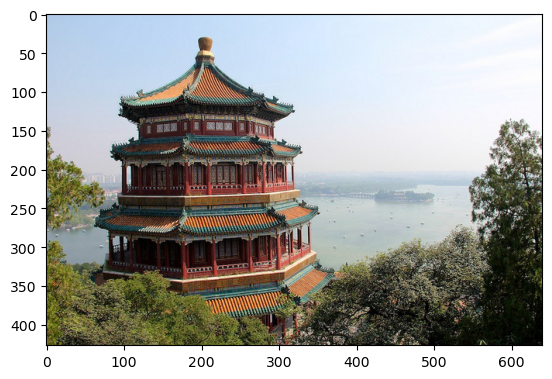

In [103]:
image = load_sample_images()['images'][0]

imgplot = plt.imshow(image)

In [104]:
image[0]

array([[174, 201, 231],
       [174, 201, 231],
       [174, 201, 231],
       ...,
       [250, 251, 255],
       [250, 251, 255],
       [250, 251, 255]], dtype=uint8)

In [105]:
image.shape

(427, 640, 3)

In [108]:
image[0][:, 0]

array([174, 174, 174, 174, 174, 174, 174, 174, 173, 172, 172, 173, 172,
       172, 172, 174, 175, 174, 173, 174, 176, 176, 175, 176, 177, 177,
       176, 176, 176, 177, 177, 177, 178, 177, 177, 179, 180, 179, 178,
       178, 178, 179, 179, 178, 178, 179, 179, 179, 179, 179, 180, 180,
       180, 180, 180, 180, 180, 179, 179, 179, 180, 181, 180, 180, 181,
       181, 182, 182, 182, 181, 179, 179, 182, 181, 181, 180, 181, 181,
       181, 181, 183, 183, 183, 182, 182, 182, 183, 183, 183, 184, 183,
       182, 183, 184, 184, 184, 184, 184, 184, 184, 185, 185, 185, 186,
       185, 186, 186, 186, 186, 186, 186, 186, 185, 186, 186, 186, 186,
       186, 186, 186, 187, 187, 187, 187, 187, 186, 186, 186, 186, 186,
       187, 187, 187, 187, 187, 187, 187, 187, 187, 186, 187, 187, 188,
       188, 188, 188, 187, 188, 189, 188, 187, 188, 188, 188, 188, 188,
       188, 188, 188, 188, 188, 187, 187, 187, 187, 188, 188, 188, 188,
       188, 188, 189, 190, 190, 191, 191, 190, 191, 191, 191, 18

In [109]:
image[0][:, 1]

array([201, 201, 201, 201, 201, 201, 201, 201, 202, 201, 201, 202, 201,
       201, 201, 203, 204, 203, 202, 203, 203, 203, 202, 203, 204, 204,
       203, 203, 203, 204, 204, 204, 205, 204, 204, 206, 207, 206, 205,
       205, 205, 206, 206, 205, 205, 206, 206, 206, 206, 206, 207, 207,
       207, 207, 207, 207, 207, 206, 206, 206, 207, 208, 207, 207, 208,
       208, 209, 209, 209, 208, 208, 208, 209, 208, 208, 209, 210, 210,
       210, 210, 210, 210, 210, 209, 209, 209, 210, 210, 210, 211, 210,
       209, 210, 211, 211, 211, 211, 211, 211, 211, 212, 212, 212, 213,
       212, 213, 213, 213, 213, 213, 213, 213, 212, 213, 213, 213, 213,
       213, 213, 213, 214, 214, 214, 214, 214, 213, 213, 213, 213, 213,
       214, 214, 214, 214, 214, 214, 214, 214, 214, 213, 212, 212, 213,
       213, 213, 213, 212, 213, 214, 213, 214, 215, 215, 215, 215, 215,
       215, 215, 215, 215, 215, 214, 214, 214, 214, 215, 215, 215, 215,
       215, 215, 214, 215, 215, 216, 216, 215, 216, 216, 216, 21

In [110]:
image[0][:, 2]

array([231, 231, 231, 231, 231, 231, 231, 231, 232, 231, 231, 232, 231,
       231, 231, 233, 234, 233, 232, 233, 233, 233, 232, 233, 234, 234,
       233, 233, 233, 234, 234, 234, 235, 234, 234, 236, 237, 236, 235,
       235, 235, 236, 236, 235, 235, 236, 236, 236, 236, 236, 237, 237,
       237, 237, 237, 237, 237, 236, 236, 236, 237, 238, 237, 237, 238,
       238, 239, 239, 239, 238, 238, 238, 239, 238, 238, 239, 240, 240,
       240, 240, 240, 240, 240, 239, 239, 239, 240, 240, 240, 241, 240,
       239, 240, 241, 241, 241, 241, 241, 241, 241, 242, 242, 242, 243,
       242, 243, 243, 243, 243, 243, 242, 242, 241, 242, 242, 242, 242,
       242, 242, 242, 244, 244, 244, 244, 244, 243, 243, 243, 243, 243,
       243, 243, 243, 243, 243, 243, 243, 243, 243, 242, 243, 243, 244,
       244, 244, 244, 243, 244, 245, 244, 243, 244, 244, 244, 244, 244,
       244, 244, 244, 244, 244, 243, 243, 243, 243, 244, 244, 244, 244,
       244, 244, 244, 245, 245, 246, 246, 245, 246, 246, 246, 24

What do the dimensions of our image above represent?

Tensors with higher numbers of dimensions have a higher **rank**.

A matrix with rows and columns only, like the black and white numbers, has **rank 2**.

A matrix with a third dimension, like the color pictures above, has **rank 3**.

When we flatten an image by stacking the rows in a column, we are decreasing the rank. 

In [111]:
flat_image = image.reshape(-1, 1)

flat_image.T.shape

(1, 819840)

In [112]:
427*640*3

819840

In [115]:
image.flatten().shape

(819840,)

In [116]:
flat_image.shape

(819840, 1)

## TensorFlow has more levers and buttons, but Keras is more user-friendly

Coding directly in **Tensorflow** allows you to tweak more parameters to optimize performance. The **Keras** wrapper makes the code more accessible for developers prototyping models.

![levers](images/levers.jpeg)

### Keras, an API with an intentional UX

- Deliberately design end-to-end user workflows
- Reduce cognitive load for your users
- Provide helpful feedback to your users

[full article here](https://blog.keras.io/user-experience-design-for-apis.html)<br>
[full list of why to use Keras](https://keras.io/why-use-keras/)

### A few comparisons

While you **can leverage both**, here are a few comparisons.

| Comparison | Keras | Tensorflow|
|------------|-------|-----------|
| **Level of API** | high-level API | High and low-level APIs |
| **Speed** |  can *seem* slower |  is a bit faster |
| **Language architecture** | simple architecture, more readable and concise | straight tensorflow is a bit more complex |
| **Debugging** | less frequent need to debug | difficult to debug |
| **Datasets** | usually used for small datasets | high performance models and large datasets that require fast execution|

This is also a _**non-issue**_ - as you can leverage `tensorflow` commands within `keras` and vice versa. If Keras ever seems slower, it's because the developer's time is more expensive than the GPUs'. Keras is designed with the developer in mind. 

[reference link](https://www.edureka.co/blog/keras-vs-tensorflow-vs-pytorch/)